In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader
import torchaudio

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score
from sklearn.utils import shuffle

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa
from transformers import AutoFeatureExtractor

from models.basic_transformer import BasicTransformer

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQUENCE_LENGTH = 6_000
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [3]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [4]:
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train_filenames.csv'))
val_data = pd.read_csv(os.path.join(DATA_DIR, 'val_filenames.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))

train_data = shuffle(train_data).reset_index(drop=True)
val_data = shuffle(val_data).reset_index(drop=True)
test_data = shuffle(test_data).reset_index(drop=True)

In [5]:
train_dataset = Dataset.from_pandas(train_data)
train_dataset = train_dataset.class_encode_column("label")

val_dataset = Dataset.from_pandas(val_data)
val_dataset = val_dataset.class_encode_column("label")

test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.class_encode_column("label")

Stringifying the column:   0%|          | 0/472 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/472 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/159 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/159 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/172 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/172 [00:00<?, ? examples/s]

In [6]:
def convert_to_path(example):
    if example["label"] == 0:
        example['signal'] = os.path.join(NORM_DIR, example["file_name"])
    elif example["label"] == 1:
        example['signal'] = os.path.join(APHASIA_DIR, example["file_name"])
    return example

train_dataset = train_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))
val_dataset = val_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))
test_dataset = test_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Map:   0%|          | 0/172 [00:00<?, ? examples/s]

In [7]:
mfcc_class = torchaudio.transforms.MFCC(sample_rate=8_000, n_mfcc=MFCC, log_mels=True, melkwargs={"n_fft": 600, "win_length": 400, "hop_length": 200, "n_mels": 200})

def preprocess_function_mfcc(examples):
    audio_arrays = []
    for x in examples:
        mfcc = mfcc_class(torch.Tensor(x["array"]))[..., :SEQUENCE_LENGTH]
        
        mfcc = nn.functional.pad(mfcc, (0, SEQUENCE_LENGTH - mfcc.shape[-1]), mode="constant")
        audio_arrays.append(mfcc.numpy())
    return torch.Tensor(audio_arrays)

In [8]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

def split_into_windows(signal, window_size=20 * 8000, step=20 * 8000):
    return [signal[i : i + window_size] for i in range(0, len(signal) - window_size + 1, step)]


def collate_batch(batch):
    time_series = list(map(lambda item: item["signal"], batch))
    target = list(map(lambda item: item['label'], batch))
    
    return time_series, torch.tensor(target)

def step_scheduler(optimizer, step_size):
    # warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=start_factor, end_factor=1.0, total_iters=warmup_dur)
    # cos_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    # warnup_then_cos_anneal = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup, cos_annealing], milestones=[warmup_dur])
    step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.01)
    return step_lr

def train_model(model, dataset_train, dataset_val, epochs=1, lr=0.001, shuffle_train=False, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    dl_train = DataLoader(dataset_train, batch_size=32, shuffle=shuffle_train, drop_last=True, collate_fn=collate_batch, generator=gen, num_workers=4)
    dl_val = DataLoader(dataset_val, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_batch, generator=gen, num_workers=4)
    
    scheduler = step_scheduler(optimizer, 30) 
        
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for ts, target in dl_train:
            ts = preprocess_function_mfcc(ts)
            ts = ts.permute(0, 2, 1)
            ts, target = ts.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(ts)
            
            # train_acc.append(torch.tensor(torch.argmax(output, dim=1) == target).cpu().detach().numpy())
            preds = torch.argmax(output, dim=1).cpu().detach().numpy()
            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        # print(f"LR before: {optimizer.param_groups[0]['lr']}")
        scheduler.step(epoch=epoch)
        # print(f"LR after: {optimizer.param_groups[0]['lr']}")
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(dataset_train)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for ts, target in dl_val:
                ts = preprocess_function_mfcc(ts)
                ts = ts.permute(0, 2, 1)
                ts, target = ts.to(device), target.to(device)
                
                output = model(ts)
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output, target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dataset_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if epoch % 10 == 0:
            tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}, lr: {optimizer.param_groups[0]['lr']}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [9]:
transformer = BasicTransformer(input_dim=MFCC, sequence_length=SEQUENCE_LENGTH, hidden_dim=32, num_layers=10, num_heads=4, num_classes=2, dropout=0.1)

In [10]:
transformer, train_l, val_l, train_accuracy, val_accuracy = train_model(transformer, train_dataset, val_dataset, epochs=50, lr=1e-6, shuffle_train=True, device=DEVICE)

Training model:   2%|▏         | 1/50 [00:49<40:01, 49.01s/it]

Epoch 0: train loss: 0.023, train balanced acc: 0.25, test loss: 0.019, test balanced acc: 0.27, lr: 1e-06


Training model:  22%|██▏       | 11/50 [08:56<31:44, 48.83s/it]

Epoch 10: train loss: 0.021, train balanced acc: 0.27, test loss: 0.018, test balanced acc: 0.34, lr: 1e-06


Training model:  42%|████▏     | 21/50 [17:08<23:57, 49.57s/it]

Epoch 20: train loss: 0.020, train balanced acc: 0.70, test loss: 0.017, test balanced acc: 0.73, lr: 1e-06


Training model:  62%|██████▏   | 31/50 [25:24<15:59, 50.50s/it]

Epoch 30: train loss: 0.019, train balanced acc: 0.75, test loss: 0.016, test balanced acc: 0.73, lr: 1e-08


Training model:  82%|████████▏ | 41/50 [33:58<07:41, 51.29s/it]

Epoch 40: train loss: 0.019, train balanced acc: 0.75, test loss: 0.016, test balanced acc: 0.73, lr: 1e-08


Training model: 100%|██████████| 50/50 [41:44<00:00, 50.09s/it]


In [11]:
def test_model(model, test_data):
    model = model.to("cpu")
        
    model.eval()
    preds = []
    with torch.no_grad():
        for sgnl, target in zip(test_data["signal"], test_data["label"]):
            sgnl = preprocess_function_mfcc([sgnl])
            sgnl = sgnl.permute(0, 2, 1)

            label = model(sgnl).to("cpu").detach().numpy().squeeze()
            preds.append(label.argmax(axis=-1))
    preds = np.array(preds)
    
    print(f"Accuracy: {accuracy_score(test_data["label"], preds)}")
    print(f"F1 Score: {f1_score(test_data["label"], preds)}")
    print(f"Recall: {recall_score(test_data["label"], preds)}")
    print(f"Precision: {precision_score(test_data["label"], preds)}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(test_data["label"], preds)}")
    return preds

In [12]:
test_model(transformer, test_dataset)

Accuracy: 0.5465116279069767
F1 Score: 0.5851063829787234
Recall: 0.4230769230769231
Precision: 0.9482758620689655
Balanced Accuracy: 0.6758241758241759


array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

Text(0.5, 0, 'Epoch')

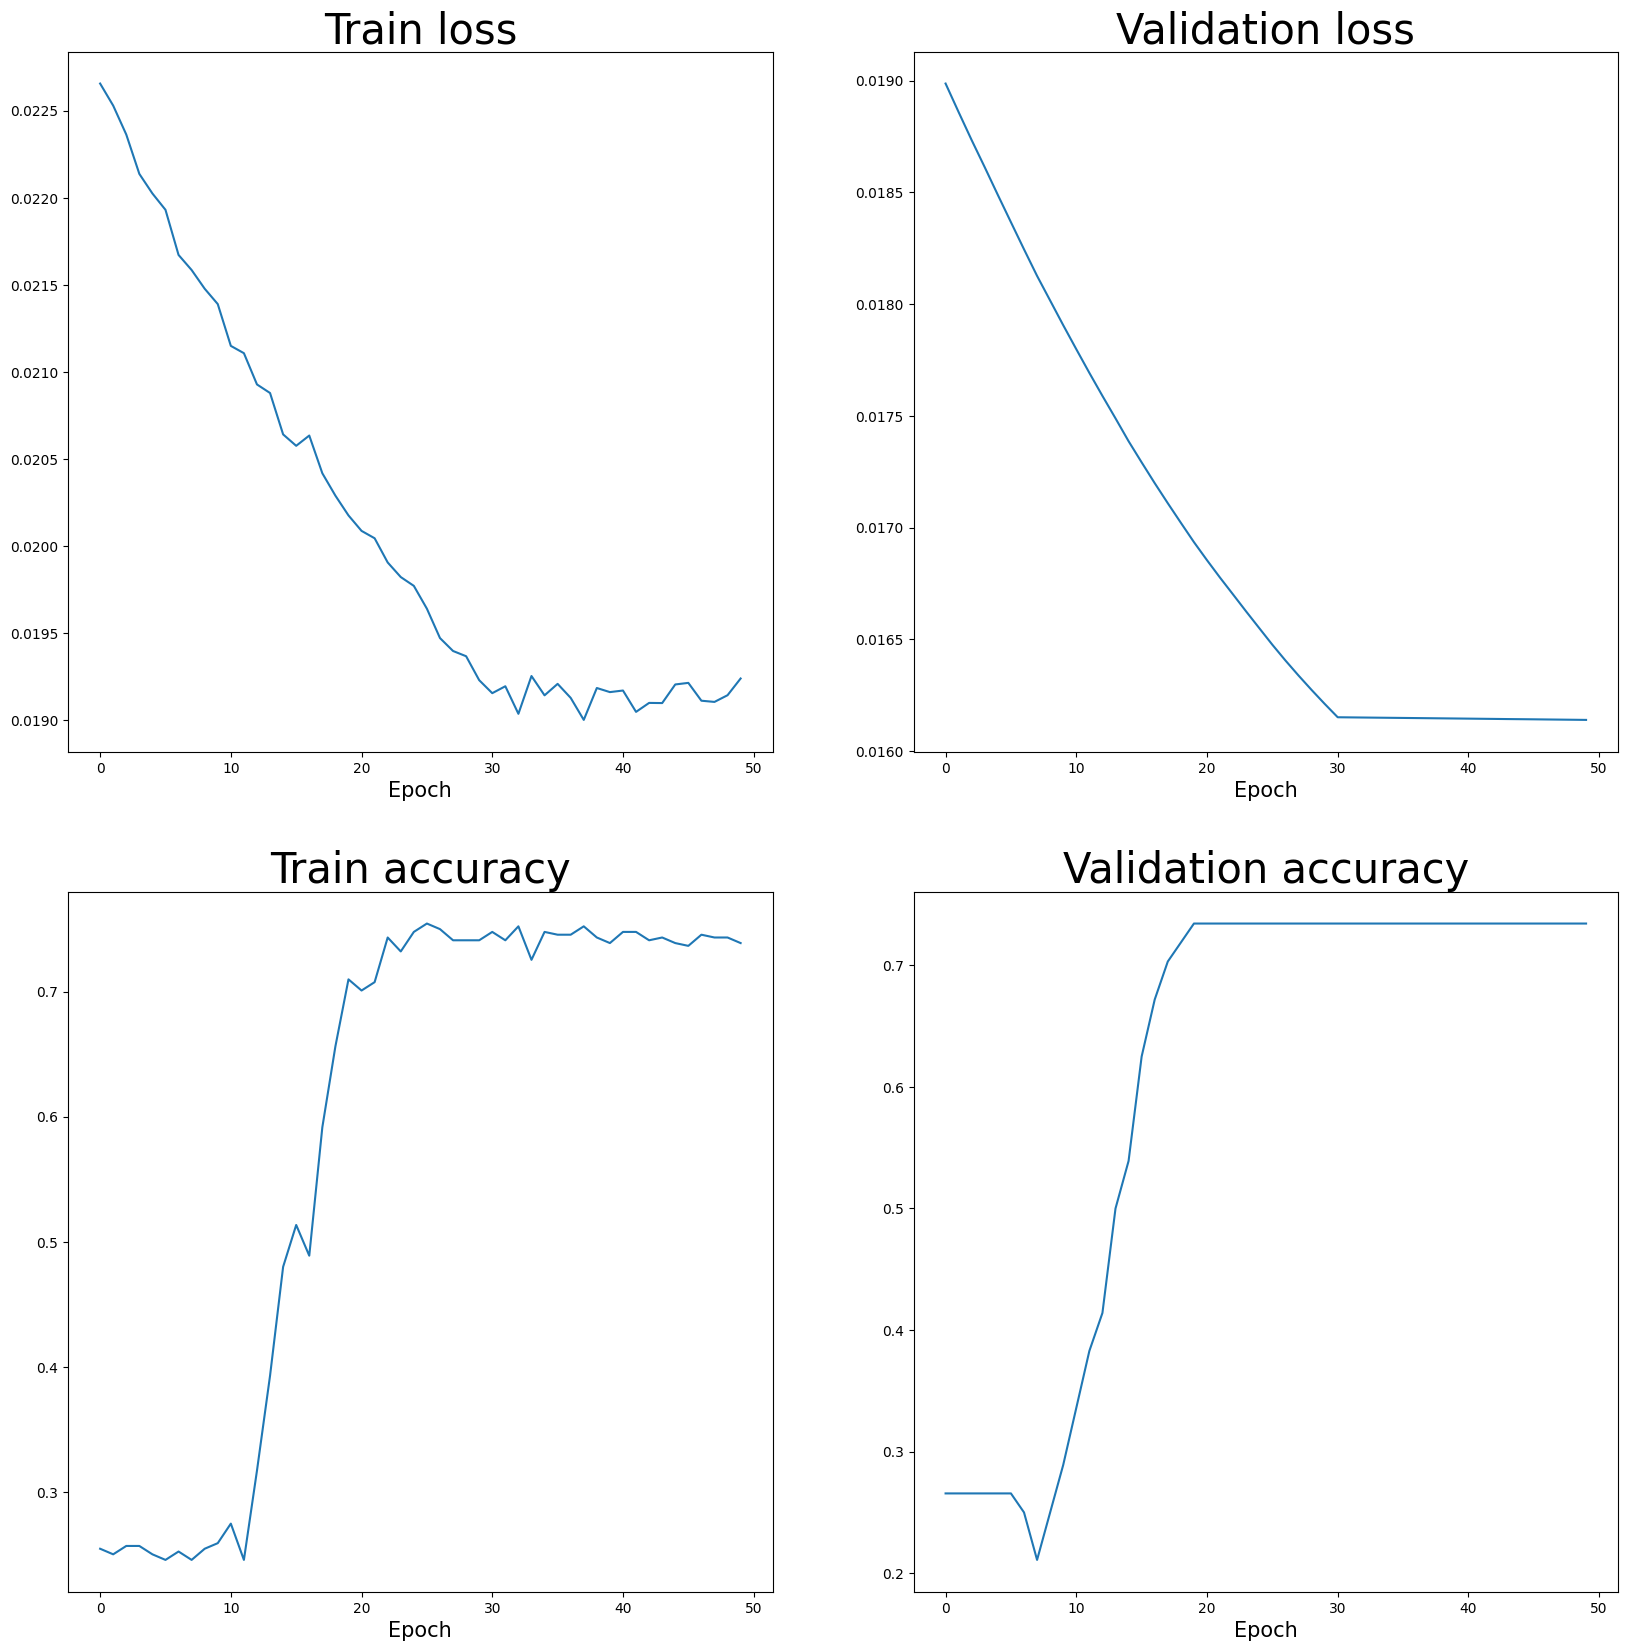

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [14]:
total_params = sum(p.numel() for p in transformer.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 260834
